# https://www.kaggle.com/code/donjoeml/map-of-energy-consumption-in-europe-plotly
## Progetto Analisi sull'utilizzo dell'energia mondiale
In questo progetto ci siamo chiesti:

1) Come sta cambiando il sistema energetico in ogni paese dal 1965 a oggi?

2) I nostri paesi stanno facendo progressi nella riduzione della produzione di elettricità da fonti ad alto contenuto di carbonio?

3) Come stiamo compensando questa riduzione? Rinnovabili o nucleare?

In [1]:
! pip install geopandas

     |████████████████████████████████| 1.0 MB 8.5 MB/s 
     |████████████████████████████████| 6.3 MB 48.2 MB/s 
     |████████████████████████████████| 16.7 MB 48.3 MB/s 


In [2]:
#Importing the libraries
import numpy as np
import pandas as pd
import geopandas as gpd
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import glob
import ipywidgets as widgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
! rm *.csv
! wget https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/Primary-energy-consumption-from-fossilfuels-nuclear-renewables.csv /content/
! wget https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/global_power_plant_database_last.csv /content/
! wget https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/share-elec-produc-by-source.csv /content/
! wget https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/share-energy-consum-by-source.csv /content/
! wget https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/population_by_country_2020.csv /content/

rm: cannot remove '*.csv': No such file or directory
--2022-05-05 08:36:03--  https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/Primary-energy-consumption-from-fossilfuels-nuclear-renewables.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145200 (142K) [text/plain]
Saving to: ‘Primary-energy-consumption-from-fossilfuels-nuclear-renewables.csv’

Primary-energy-cons 100%[===================>] 141.80K  --.-KB/s    in 0.02s   

2022-05-05 08:36:03 (8.87 MB/s) - ‘Primary-energy-consumption-from-fossilfuels-nuclear-renewables.csv’ saved [145200/145200]

/content/: Scheme missing.
FINISHED --2022-05-05 08:36:03--
Total wall clock time: 0.4s
Downloaded: 1 files, 142K in 0.02s (8.87 MB/s)
--2022-05-05 08:36:03--  https://raw.githubusercontent

1) 
Importiamo il dataset contenente la percentuale di energia consumata per tipologia (rinnovabile, nucleare, carbone) dal 1965 al 2020 per ogni nazione.



In [4]:
energy_cons = pd.read_csv("Primary-energy-consumption-from-fossilfuels-nuclear-renewables.csv", low_memory=False)
energy_cons.drop(["Code"], axis=1).head()

,Entity,Year,Fossil fuels (% sub energy),Renewables (% sub energy),Nuclear (% sub energy)
0,Africa,1965,94.463,5.537,0.0
1,Africa,1966,94.127,5.873,0.0
2,Africa,1967,93.920,6.080,0.0
3,Africa,1968,93.257,6.743,0.0
4,Africa,1969,92.317,7.683,0.0


In [5]:
# GeoPandas è una libreria di pandas per gestire dati geografici, mi importo un dataset con le coordinate delle nazioni
# per poter creare delle mappe

country_dataset = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
country_dataset = country_dataset.drop(["pop_est","iso_a3","geometry","gdp_md_est"], axis=1)

In [6]:
# Nel nostro dataset energy_cons sui contry ci sono anche i continenti come "Africa", dunque dovremmo eseguire
# un left merge in maniera da manteri valori di energy_cons e mettere a nan quelli che non trovano corrispondeza
# altrimenti con un inner scarteremmo tutti i valori cui entity != name

df = energy_cons.merge(country_dataset, left_on = "Entity", right_on="name", how="left").drop(columns=["name"])
df

,Entity,Code,Year,Fossil fuels (% sub energy),Renewables (% sub energy),Nuclear (% sub energy),continent
0,Africa,NaN,1965,94.463,5.537,0.000,NaN
1,Africa,NaN,1966,94.127,5.873,0.000,NaN
2,Africa,NaN,1967,93.920,6.080,0.000,NaN
3,Africa,NaN,1968,93.257,6.743,0.000,NaN
4,Africa,NaN,1969,92.317,7.683,0.000,NaN
...,...,...,...,...,...,...,...
4279,World,OWID_WRL,2015,85.839,9.842,4.319,NaN
4280,World,OWID_WRL,2016,85.459,10.241,4.300,NaN
4281,World,OWID_WRL,2017,85.123,10.640,4.237,NaN
4282,World,OWID_WRL,2018,84.846,10.959,4.193,NaN


In [7]:
print(f"valori nulli per continente : {np.count_nonzero(df.continent.isna())}")
print(f"Entity senza continent trovato :  {df.loc[pd.isna(df.continent),:].Entity.unique()}")

valori nulli per continente : 415
Entity senza continent trovato :  ['Africa' 'Europe' 'Hong Kong' 'North America' 'North Macedonia'
 'Singapore' 'United States' 'World']


In [8]:
# Prepariamo un dataset per un continente
continents = df.continent.unique()
continents = continents[~pd.isna(continents)]
c_dropdown = widgets.Dropdown(
    options=continents,
    value='Europe',
    description='Select Continent:',
    disabled=False,
    continuous_update=True
)

display(c_dropdown)

Dropdown(description='Select Continent:', index=3, options=('Africa', 'South America', 'Oceania', 'Europe', 'A…

In [9]:
selected_continent = c_dropdown.value
df.loc[df["Entity"] == selected_continent]["continent"] = selected_continent
df_continent = df.loc[df["continent"] == selected_continent].reset_index(drop=True)
df_continent.columns = map(lambda c: c.replace(" (% sub energy)", ''), df_continent.columns)
df_continent.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Entity,Code,Year,Fossil fuels,Renewables,Nuclear,continent
0,Austria,AUT,1965,76.060,23.940,0.0,Europe
1,Austria,AUT,1966,75.340,24.660,0.0,Europe
2,Austria,AUT,1967,75.069,24.931,0.0,Europe
3,Austria,AUT,1968,76.058,23.942,0.0,Europe
4,Austria,AUT,1969,78.788,21.212,0.0,Europe


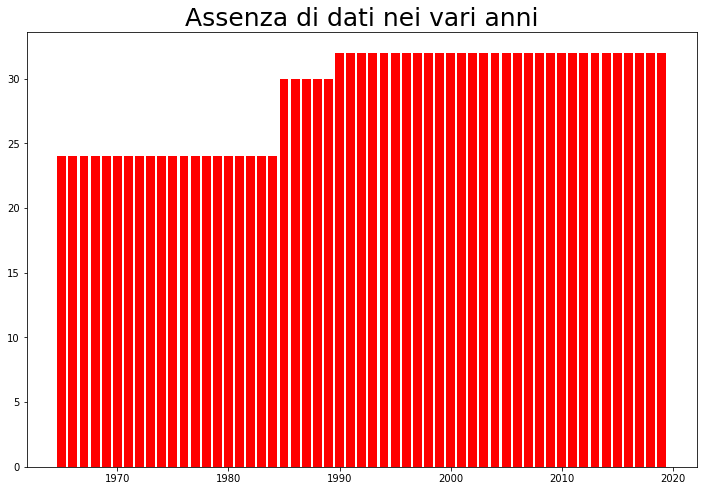

In [10]:
## Possiamo notare come dal 1990 i dati sono tutti presenti mentre prima mancano
year = list(df_continent["Year"].unique())
y = []
for i in year:
  temp = df_continent.loc[df_continent["Year"] == i, ["Year"]].count()
  y.append(temp[0])

plt.figure(figsize=(12,8))
plt.title("Assenza di dati nei vari anni", fontsize = 25)
plt.bar(year,y, color='red')
plt.show()

In [11]:
df_continent.head()

,Entity,Code,Year,Fossil fuels,Renewables,Nuclear,continent
0,Austria,AUT,1965,76.060,23.940,0.0,Europe
1,Austria,AUT,1966,75.340,24.660,0.0,Europe
2,Austria,AUT,1967,75.069,24.931,0.0,Europe
3,Austria,AUT,1968,76.058,23.942,0.0,Europe
4,Austria,AUT,1969,78.788,21.212,0.0,Europe


In [12]:
#@title Vediamo l'andamento temporale dell'utilizzo dell'energia in Europa

fig = px.line(df_continent.groupby(by=["Year"]).mean().reset_index(), x="Year", y=["Nuclear", "Fossil fuels", "Renewables"])
fig.update_yaxes(showticklabels=True)
fig.update_layout(title={'text': '<b>Andamenti energetici nel tempo</b>'})
fig.update_layout(
    autosize=False,
    width=800,
    height=500,)
fig.show()

In [13]:
#@title Tipi di fonti rinnovabili e combustibili utilizzati in Europa

elec_prod = pd.read_csv("share-elec-produc-by-source.csv", low_memory=False)
countries = df_continent.Entity.unique()
cont = elec_prod[elec_prod.Entity.isin(countries)].reset_index(drop=True)
cont.columns = map(lambda c: c.replace(" (% electricity)",''), cont.columns)

layout = dict(
    autosize = True,
    width = 700,
    height = 500,
    plot_bgcolor='rgba(0,0,0,0.1)',
    showlegend=True
    )

year = cont.Year.max()

slider = widgets.IntSlider(
    value=cont.Year.max(),
    min=cont.Year.min(),
    max=cont.Year.max(),
    step=1,
    description='Year:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

def f(i):
  year = i
  fig = make_subplots(rows=1, cols=2, 
                        specs=[[{"type": "Pie"}, {"type": "Pie"}]], 
                        subplot_titles=(f'Fonti rinnovabili Europa', f'Combustibili Europa'))

  # first bar "Europe"
  df2 = cont[cont['Year']==year].reset_index(drop=True)
  df3=df2.copy()
  x1 = ['Hydro', 'Solar', 'Wind', 'Other renewables']
  y1 = [df3['Hydro'].mean(), df3['Solar'].mean(), df3['Wind'].mean(), df3['Other renewables'].mean()]
  fig.add_trace(go.Pie(
              labels=x1, values=y1,
              text=y1,
              texttemplate = '%{text:.2s}%',
              hole=.3
          ), row=1, col=1)

  df4=df2.copy()
  x1 = ['Coal', 'Gas', 'Oil']
  y1 = [df4['Coal'].mean(), df4['Gas'].mean(), df4['Oil'].mean()]
  fig.add_trace(go.Pie(
              labels=x1, values=y1,
              text=y1,
              #texttemplate = '%{text:.2s}%',
              hole=.3
          ), row=1, col=2)
  
  #colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen'] 
  fig.update_traces(textinfo='label+percent', textfont_size=20,
                  marker=dict(line=dict(color='#000000', width=2)))
  fig.update_traces(textposition='inside')
  fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide') 
  fig.update_layout(layout)
  fig.show()

interact(f, i=slider)

interactive(children=(IntSlider(value=2020, description='Year:', max=2020, min=1985), Output()), _dom_classes=…

<function __main__.f>

In [14]:
#@title Utilizzo di energia medio per tipologia e per anno in Europa
en = ["Nuclear", "Renewables", "Fossil"]
slider = widgets.IntSlider(
      value=df_continent.Year.max(),
      min=df_continent.Year.min(),
      max=df_continent.Year.max(),
      step=1,
      description='Year:',
      disabled=False,
      continuous_update=True,
      orientation='horizontal',
      readout=True,
      readout_format='d'
  )
def f(i):
  year = i
  y = [df_continent.loc[df_continent["Year"]==year]["Nuclear"].mean(),
               df_continent.loc[df_continent["Year"]==year]["Renewables"].mean(),
               df_continent.loc[df_continent["Year"]==year]["Fossil fuels"].mean()]
  plt.figure(figsize=(10,8))
  plt.bar(en, y, color = ["yellow","orange","red"])
  plt.ylabel("% energy consumed")
  plt.title("MEAN OF ENERGY TYPE COSUMED")
  for index,data in enumerate(y):
    plt.text(x=index , y =data+1 , s=f"{int(data)}%" , fontdict=dict(fontsize=12))
  plt.tight_layout()

  plt.show()

interact(f, i=slider)

interactive(children=(IntSlider(value=2019, description='Year:', max=2019, min=1965), Output()), _dom_classes=…

<function __main__.f>

In [15]:
#@title Sviluppo di energia nucleare nel corso degli anni
fig = px.choropleth(df_continent,
    locations='Code',
    color='Nuclear',
    locationmode='ISO-3',
    animation_frame="Year",
    animation_group='Nuclear'
)

fig.update_layout(
    title=dict(
        text='Produzione di energia da fonte Nucleare',
        x=.5,
        font_size=18,
        ),

    geo=dict(
        bgcolor='#8ad6ff',
        lakecolor='#8ad6ff',
        projection_type='miller',
        scope=selected_continent.lower()
        ),
    
    width = 700,
    height = 700,
    coloraxis=dict(colorscale='Reds',cmin=df_continent['Nuclear'].min(),cmax=df_continent['Nuclear'].max())
)

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 100
fig.show()

In [16]:
#@title Produzione di energia rinonvabile nel corso degli anni
fig = px.choropleth(df_continent,
    locations='Code',
    color='Renewables',
    locationmode='ISO-3',
    animation_frame="Year",
)

fig.update_layout(
    title=dict(
        text='Produzione di energia da fonti rinnovabili',
        x=.5,
        font_size=18,
        ),

    geo=dict(
        bgcolor='#8ad6ff',
        lakecolor='#8ad6ff',
        projection_type='miller',
        scope=selected_continent.lower()
        ),
    
    width = 700,
    height = 700,
    coloraxis=dict(colorscale='Blues',cmin=df_continent['Renewables'].min(),cmax=df_continent['Renewables'].max())
)

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 100
fig.show()

In [17]:
#@title Produzione di energia derivante da combustibili fossili nel corso degli anni
fig = px.choropleth(df_continent,
    locations='Code',
    color='Fossil fuels',
    locationmode='ISO-3',
    animation_frame="Year",
)

fig.update_layout(
    title=dict(
        text='Produzione di energia da combustibili fossili',
        x=.5,
        font_size=18,
        ),

    geo=dict(
        bgcolor='#8ad6ff',
        lakecolor='#8ad6ff',
        projection_type='miller',
        scope=selected_continent.lower()
        ),
    
    width = 700,
    height = 700,
    coloraxis=dict(colorscale='Greens',cmin=df_continent['Fossil fuels'].min(),cmax=df_continent['Fossil fuels'].max())
)

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 100
fig.show()

## 2) Compensiamo con il nucleare o con le energie rinnovabili?
Vediamo come nel continente europa, i paese negli ultimi anni reagiscono al meno utilizzo del carbone

Il metodo scelto per quantificare è :
-fossil x (renewables - nuclear)

l'idea di base è quella di utilizzare i coefficieti di una regressione lineare (pendenza della funzione) per ogni country,, calcolati attraverso la formula sopra descritta, in modo da capire se chi e come compensa la diminuzione dell'utilizzo del fossil fuels.
In generale analizziamo la differenza tra le due energie (R e N) confrontandoli con il descrescente utilizzo del fossile.


In [18]:
# con il regressore cerchiamo i coefficienti della funzione in modo da stimare la pendenza
# si crea un nuovo df contenente un record per ogni nazione con il relativo coeff di regressione
from sklearn.linear_model import LinearRegression
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning) # sklearn vuole che usiamo le pipelines

regr = LinearRegression(normalize=True)

list_=df_continent['Entity'].unique()
dff = pd.DataFrame(index=range(len(list_)),columns=["Entity", "R/F",'continent'])

Y=['Nuclear','Fossil fuels','Renewables']


for l in range(len(list_)):
    df3=df_continent[df_continent['Entity']==list_[l]]

    X = df3[['Year']]

    z = np.zeros(3)
    for i in range(len(Y)):
        y=df3[[Y[i]]]
        regr.fit(X, y)
        z[i]=regr.coef_

    out2= -z[1] * ( z[2] - z[0] )

    dff.at[l,'Entity'] = list_[l]
    dff.at[l,'R/F'] = out2
    dff.at[l,'continent'] = selected_continent
    
dff['R/F'] = pd.to_numeric(dff['R/F'])
dff.sort_values("R/F", inplace = True, ignore_index=True)

In [19]:
#@title L'ISLANDA risulta essere la nazione con coefficiente massimo, dunque possiamo affermare che ha un decremento di combustile fossile, corrisponde un aumento delle fonti RINNOVABILI
c_max = dff['Entity'].iloc[dff['R/F'].idxmax()]
df3=df_continent[df_continent['Entity']==dff['Entity'].iloc[dff['R/F'].idxmax()]]

fig = px.line(df3, x='Year', y=Y)
fig.update_layout(title={'text': f'<b>{c_max}</b>'})
fig.update_layout(
    autosize=False,
    width=800,
    height=500,)
fig.show()

In [20]:
#@title La FRANCIA risulta essere la nazione con coefficiente minimo, dunque possiamo affermare che ha un decremento di combustile fossile, corrisponde un aumento del NUCLEARE
c_min = dff['Entity'].iloc[dff['R/F'].idxmin()]
df4=df_continent[df_continent['Entity']==dff['Entity'].iloc[dff['R/F'].idxmin()]]

fig = px.line(df4, x='Year', y=Y)
fig.update_layout(title={'text': f'<b>{c_min}</b>'})
fig.update_layout(
    autosize=False,
    width=800,
    height=500,)
fig.show()

In [21]:
#@title Mettiamo a confronto le due nazioni con tasso di innovazione più alto
layout = dict(
    autosize = True,
    width = 1000,
    height = 500,
    plot_bgcolor='rgba(0,0,0,0.1)',
    showlegend=False
    )

year = df_continent.Year.max()

slider = widgets.IntSlider(
    value=df_continent.Year.max(),
    min=df_continent.Year.min(),
    max=df_continent.Year.max(),
    step=1,
    description='Year:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

def f(i):
  year = i
  fig = make_subplots(rows=1, cols=2, 
                        specs=[[{"type": "bar"}, {"type": "bar"}]], 
                        subplot_titles=(c_max, c_min))

  # first bar "Iceland"
  df2 = df_continent[df_continent['Year']==year].reset_index(drop=True)
  df3=df2[df2['Entity']==c_max]
  x1 = ['Nuclear', 'Fossil', 'Renewables']
  y1 = [df3['Nuclear'].mean(), df3['Fossil fuels'].mean(), df3['Renewables'].mean()]
  fig.add_trace(go.Bar(
              x=x1, y=y1,
              text=y1,
              texttemplate = '%{text:.2s}%',
              textposition='auto',
              marker_color=['red','black','green'],
              width=.8,
          ), row=1, col=1)

  # first bar "France"
  df3=df2[df2['Entity']==c_min]
  x1 = ['Nuclear', 'Fossil', 'Renewables']
  y1 = [df3['Nuclear'].mean(), df3['Fossil fuels'].mean(), df3['Renewables'].mean()]
  fig.add_trace(go.Bar(
              x=x1, y=y1,
              text=y1,
              texttemplate = '%{text:.2s}%',
              textposition='auto',
              marker_color=['red','black','green'],
              width=.8,
          ), row=1, col=2)  
  fig.update_layout(layout)
  fig.show()

interact(f, i=slider)

interactive(children=(IntSlider(value=2019, description='Year:', max=2019, min=1965), Output()), _dom_classes=…

<function __main__.f>

In [22]:
#@title In verde troviamo le nazione che aumentano la produzione di energia da fonti rinnovabili, in rosso le nazioni che aumentano la produzione di energia nucleare
num_vis = 20
fig = go.Figure(
  go.Treemap(
    labels=dff['Entity'].to_list()[:int(num_vis/2)] + dff['Entity'].to_list()[int(-num_vis/2):],
    parents=dff['continent'].to_list()[:int(num_vis/2)] + dff['continent'].to_list()[int(-num_vis/2):],
    values=dff['R/F'].abs().to_list()[:int(num_vis/2)] + dff['R/F'].abs().to_list()[int(-num_vis/2):],
    branchvalues='total',
    marker=dict(
      colors=dff['R/F'].to_list()[:int(num_vis/2)] + dff['R/F'].to_list()[int(-num_vis/2):],
      colorscale=["darkred",'white', "darkgreen"],
      cmid=0),
  )
)
fig.show()

## 3) Analizziamo meglio l'Islanda e la Francia 
Andiamo a vedere quali fonti rinnovabili vengono maggiormente utilizzate in Islanda

In [23]:
elec_prod = pd.read_csv("share-elec-produc-by-source.csv", low_memory=False)
francia = elec_prod.loc[elec_prod.Entity == c_min].fillna(0)
islanda = elec_prod.loc[elec_prod.Entity == c_max].fillna(0)

In [24]:
islanda.columns = map(lambda c: c.replace(" (% electricity)",''), islanda.columns)
francia.columns = map(lambda c: c.replace(" (% electricity)",''), francia.columns)

In [25]:
francia.head()

,Entity,Code,Year,Coal,Gas,Hydro,Solar,Wind,Oil,Nuclear,Other renewables
1926,France,FRA,2000,5.045732,2.151406,12.400059,0.000976,0.008999,2.261274,77.573558,0.557995
1927,France,FRA,2001,3.755455,2.777621,13.619884,0.001130,0.024068,1.989412,77.221020,0.611409
1928,France,FRA,2002,4.273245,3.317915,10.909187,0.001283,0.047972,1.921317,78.890128,0.638952
1929,France,FRA,2003,4.676729,3.449310,10.497466,0.001383,0.069056,2.092418,78.551599,0.662038
1930,France,FRA,2004,4.285485,3.701181,10.471926,0.001485,0.104596,1.953191,78.817091,0.665044


In [26]:
#@title Tipi di fonti rinnovabili e combustibili utilizzati in Islanda
layout = dict(
    autosize = True,
    width = 700,
    height = 500,
    plot_bgcolor='rgba(0,0,0,0.1)',
    showlegend=True
    )

year = islanda.Year.max()

slider = widgets.IntSlider(
    value=islanda.Year.max(),
    min=islanda.Year.min(),
    max=islanda.Year.max(),
    step=1,
    description='Year:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

def f(i):
  year = i
  fig = make_subplots(rows=1, cols=2, 
                        specs=[[{"type": "Pie"}, {"type": "Pie"}]], 
                        subplot_titles=(f'Fonti rinnovabili {c_max}', f'Combustibili {c_max}'))

  # first bar "Iceland"
  df2 = islanda[islanda['Year']==year].reset_index(drop=True)
  df3=df2[df2['Entity']==c_max]
  x1 = ['Hydro', 'Solar', 'Wind', 'Other renewables']
  y1 = [df3['Hydro'].mean(), df3['Solar'].mean(), df3['Wind'].mean(), df3['Other renewables'].mean()]
  fig.add_trace(go.Pie(
              labels=x1, values=y1,
              text=y1,
              texttemplate = '%{text:.2s}%',
              hole=.3
          ), row=1, col=1)

  df4=islanda[islanda['Entity']==c_max].reset_index(drop=True)
  x1 = ['Coal', 'Gas', 'Oil']
  y1 = [df4['Coal'].mean(), df4['Gas'].mean(), df4['Oil'].mean()]
  fig.add_trace(go.Pie(
              labels=x1, values=y1,
              text=y1,
              #texttemplate = '%{text:.2s}%',
              hole=.3
          ), row=1, col=2)
  
  #colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen'] 
  fig.update_traces(textinfo='label+percent', textfont_size=20,
                  marker=dict(line=dict(color='#000000', width=2)))
  fig.update_traces(textposition='inside')
  fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide') 
  fig.update_layout(layout)
  fig.show()

interact(f, i=slider)

interactive(children=(IntSlider(value=2019, description='Year:', max=2019, min=1985), Output()), _dom_classes=…

<function __main__.f>

In [27]:
#@title Combustibili usati in Francia
layout = dict(
    autosize = True,
    width = 700,
    height = 500,
    plot_bgcolor='rgba(0,0,0,0.1)',
    showlegend=True
    )

year = francia.Year.max()

slider = widgets.IntSlider(
    value=francia.Year.max(),
    min=francia.Year.min(),
    max=francia.Year.max(),
    step=1,
    description='Year:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

def f(i):
  year = i
  fig = make_subplots(rows=1, cols=2, 
                        specs=[[{"type": "Pie"}, {"type": "Pie"}]], 
                        subplot_titles=(f'Fonti rinnovabili {c_min}', f'Combustibili {c_min}'))

  # first bar "Iceland"
  df2 = francia[francia['Year']==year].reset_index(drop=True)
  df3=df2[df2['Entity']==c_min]
  x1 = ['Hydro', 'Solar', 'Wind', 'Other renewables']
  y1 = [df3['Hydro'].mean(), df3['Solar'].mean(), df3['Wind'].mean(), df3['Other renewables'].mean()]
  if not df3.empty:
    fig.add_trace(go.Pie(
                labels=x1, values=y1,
                text=y1,
                texttemplate = '%{text:.2s}%',
                hole=.3
            ), row=1, col=1)
  
  # first bar "France"
  df2 = francia[francia['Year']==year].reset_index(drop=True)
  df3=df2[df2['Entity']==c_min]
  x1 = ['Coal', 'Gas', 'Oil']
  y1 = [df3['Coal'].mean(), df3['Gas'].mean(), df3['Oil'].mean()]
  fig.add_trace(go.Pie(
              labels=x1, values=y1,
              text=y1,
              hole=.3
            ), row = 1, col = 2)

  fig.update_traces(textinfo='label+percent', textfont_size=20,
                  marker=dict(line=dict(color='#000000', width=2)))
  fig.update_traces(textposition='inside')
  fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide') 
  fig.update_layout(layout)
  fig.show()

interact(f, i=slider)

interactive(children=(IntSlider(value=2020, description='Year:', max=2020, min=1985), Output()), _dom_classes=…

<function __main__.f>

## 4) Il terzo aspetto che andremmo a considerare è la distribuzione delle diverse centrali di energia elettrica in Europa
Esse sono suddivise per tipologia di energia prodoctto, andando a prendere come in considerazioni le centrali europe nel 2017 e la stima di energia prodotta

In [28]:
df = pd.read_csv("global_power_plant_database_last.csv", low_memory=False)

In [29]:
## consideriamo l'anno di interesse 2017

df = df[['country_long','latitude','longitude','primary_fuel','estimated_generation_gwh_2017',]]
df.head()

,country_long,latitude,longitude,primary_fuel,estimated_generation_gwh_2017
0,Afghanistan,32.322,65.1190,Hydro,119.50
1,Afghanistan,31.670,65.7950,Solar,18.29
2,Afghanistan,31.623,65.7920,Solar,18.72
3,Afghanistan,34.556,69.4787,Hydro,174.91
4,Afghanistan,34.641,69.7170,Hydro,350.80


In [30]:
#uniamo al nostro dataset i contenti per plottare la mappa

cont = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cont = cont[['name','continent']]
df = df.merge(cont, how='left', left_on='country_long', right_on='name').drop(columns=['name'])

In [31]:
# aggiungiamo il continente Europa ai paesi non riconosciuti dal merge

df.loc[pd.isna(df.continent),:].country_long.unique()
continent_map = {'Bosnia and Herzegovina':'Europe','Czech Republic':'Europe'}
for country_, continent_ in continent_map.items():
    df.loc[df.country_long==country_, 'continent'] = continent_

In [32]:
# Prendiamo in considerazione l' Europa escludendo le centrali spente

df = df[df['continent']=='Europe'].reset_index(drop=True)
df=df.dropna()
df.head()

,country_long,latitude,longitude,primary_fuel,estimated_generation_gwh_2017,continent
0,Albania,39.9116,20.1047,Hydro,88.45,Europe
1,Albania,42.2514,20.0431,Hydro,1648.24,Europe
2,Albania,42.1033,19.8224,Hydro,1982.72,Europe
3,Albania,41.3428,19.8964,Hydro,15.23,Europe
4,Albania,41.6796,19.8305,Hydro,83.57,Europe


In [36]:
#@title Mappa Scatter della distribuzioni di centrali europee attive nel 2017

color_discrete_map ={
    'Hydro':'#425fff',
    'Gas':'#f569ff',
    'Wind':'#7cfcf4',
    'Solar':'#fff94d',
    'Oil':'#45010c',
    'Waste':'#77ff52',
    'Nuclear':'#ff3838',
    'Coal':'#c9c8c5',
    'Geothermal':'#ff8000',
    'Other':'#82ffaa'
    }

fig = px.scatter_mapbox(df, 
                        lat="latitude", 
                        lon="longitude", 
                        color="primary_fuel", 
                        size="estimated_generation_gwh_2017",
                        size_max=12, 
                        color_discrete_map = color_discrete_map)


fig.update_layout(
    #mapbox_style="dark",
    mapbox_style="carto-positron",
    showlegend=True,
    
    legend=dict(
            x=.04,
            y=.96,
            title='Type',
            title_font_color='black',
            bgcolor='rgba(0,0,0,0)',
            font_color='black',
            ),
    
    mapbox=dict(
        bearing=0,
        center=go.layout.mapbox.Center(lat=52, lon=10),
        zoom=3,
            ),

    title=dict(
        text='Location and types of power plant in Europe (2017)',
        x=.5,
        font_size=25,
            ),
        width=1000,
        height=700,
    )




fig.show()

In [34]:
#@title Vediamo la produzione di energia in Italia
df1 = df.loc[df.country_long == "Italy"]
fuels = df1.primary_fuel.unique()
values = []
for f in fuels:
  temp = df1.loc[df1.primary_fuel == f,"estimated_generation_gwh_2017"].sum()
  values.append(temp)

fig = px.bar(x=fuels, y=values, color=values, title="Tipi di energia stimata in italia nel 2017", 
             labels={"x":"fonti energetiche", "y":"energia stimata"},
              text_auto='.2s', width=800, height=400)
fig.show()